In [24]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
from dateutil.parser import parse
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf
from tensorflow import keras
#%matplotlib inline
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = [15, 5]
from IPython import display
from ipywidgets import interact, widgets

In [25]:
## Read Data for Cases, Deaths and Recoveries
base = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
#base = '';
cases_raw=pd.read_csv(base + 'time_series_covid19_confirmed_global.csv', error_bad_lines=False)
deaths_raw=pd.read_csv(base + 'time_series_covid19_deaths_global.csv', error_bad_lines=False)
recoveries_raw=pd.read_csv(base + 'time_series_covid19_recovered_global.csv', error_bad_lines=False)

In [26]:
name = "Nigeria"
cases_mask = cases_raw["Country/Region"] == name
cases_specific = cases_raw[cases_mask]

death_mask = deaths_raw["Country/Region"] == name
deaths_specific = deaths_raw[death_mask]

recoveries_mask = recoveries_raw["Country/Region"] == name
recoveries_specific = recoveries_raw[recoveries_mask]

In [27]:
cases=cases_specific.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date')
deaths=deaths_specific.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Deaths',var_name='Date')
recoveries = recoveries_specific.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Recoveries',var_name='Date')

In [28]:
cases.tail()

,Province/State,Country/Region,Lat,Long,Date,Cases
105,NaN,Nigeria,9.082,8.6753,5/6/20,3145
106,NaN,Nigeria,9.082,8.6753,5/7/20,3526
107,NaN,Nigeria,9.082,8.6753,5/8/20,3912
108,NaN,Nigeria,9.082,8.6753,5/9/20,4151
109,NaN,Nigeria,9.082,8.6753,5/10/20,4399


In [29]:
number_of_days = 19
d2 = parse(cases.Date[len(cases) - 1])
d1 = d2 - timedelta(days=number_of_days)
ts_cases = pd.Series(np.array(cases.Cases[-number_of_days - 1:]), pd.date_range(d1, d2)).astype('float64')
ts_deaths = pd.Series(np.array(deaths.Deaths[-number_of_days - 1:]), pd.date_range(d1, d2)).astype('float64')
ts_recoveries = pd.Series(np.array(recoveries.Recoveries[-number_of_days - 1:]), pd.date_range(d1, d2)).astype('float64')

In [30]:
# Nigeria has one wrong datapoint that should be corrected
ts_cases["2020-03-28"] = 97

In [31]:
ts_cases.size

21

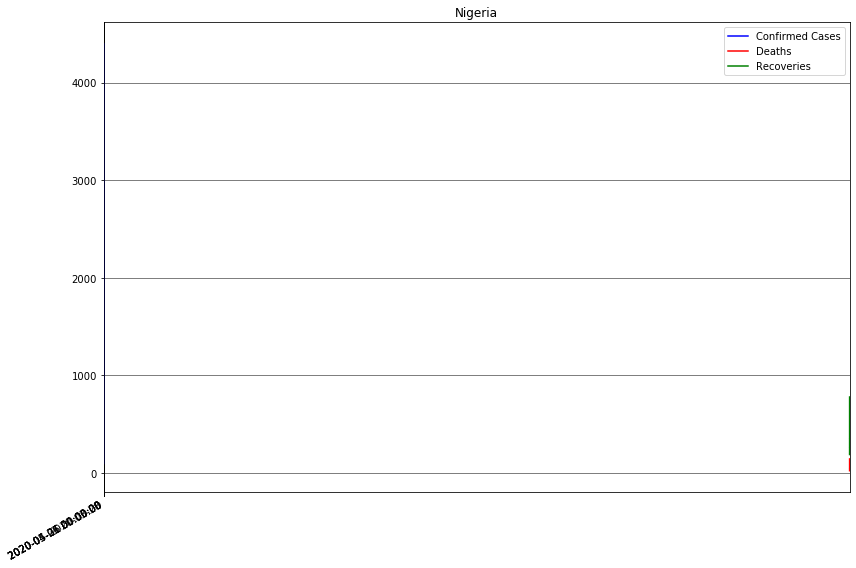

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ts_cases.plot(ax=ax, title=name, color='b')
ts_deaths.plot(ax=ax, color='r')
ts_recoveries.plot(ax=ax, color='g')
ax.legend(["Confirmed Cases", "Deaths", "Recoveries"]);
ax.grid(b='on', which='major', color='k', linewidth=0.5)
ax.grid(b='on', which='minor', color='k', linewidth=0.5)
ax.set_facecolor("w")
fig.tight_layout()

fig.savefig(name + ".png")

## AR MODELLING

### Plot

2020-05-07 00:00:00    3526.0
2020-05-08 00:00:00    3912.0
2020-05-09 00:00:00    4151.0
2020-05-10 00:00:00    4399.0
2020-03-28               97.0
dtype: float64


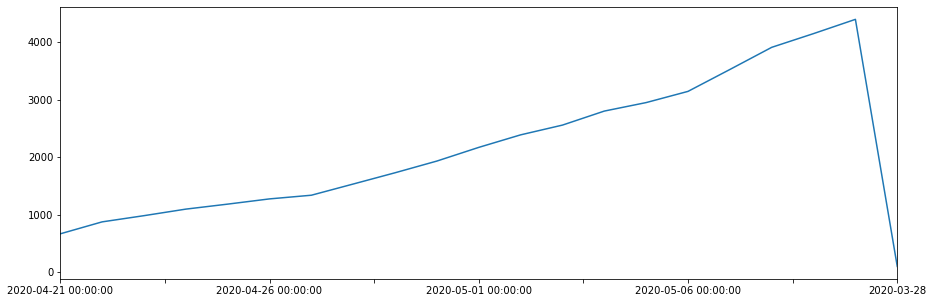

In [12]:
series = ts_cases
print(series.tail())
series.plot()
plt.show()

### Check for Autocorrelation

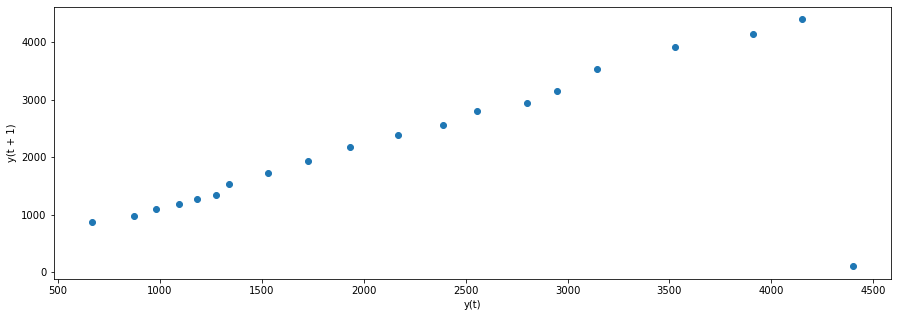

In [13]:
from pandas.plotting import lag_plot
lag_plot(series)
plt.show()

### Calculate Pearson Correlation Coefficient

In [14]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.635757
t+1  0.635757  1.000000


### Autocorrelation Plot

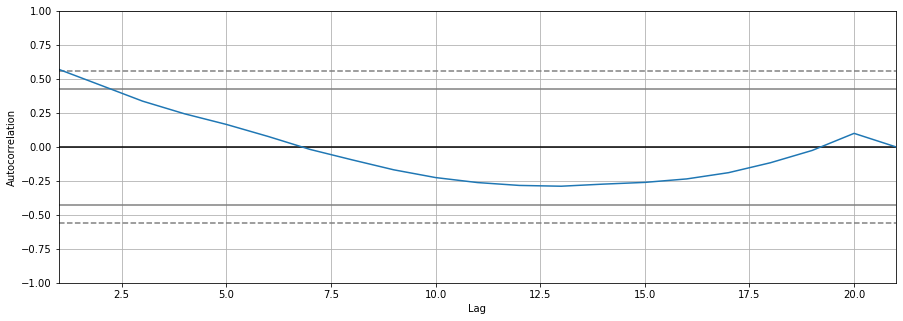

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.show()

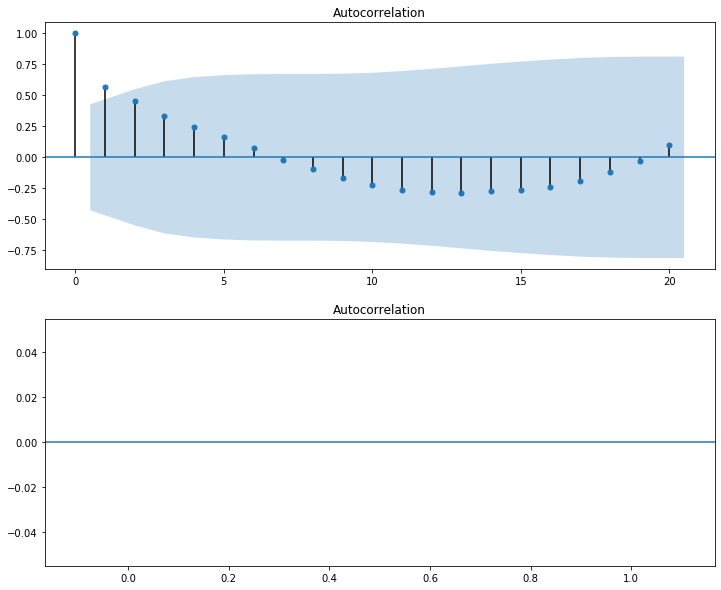

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(series, lags=20, ax=axes[0])
plot_acf(series.diff(), lags=20, ax=axes[1])
plt.show()

### Persistence Model

Test MSE: 2711416.429


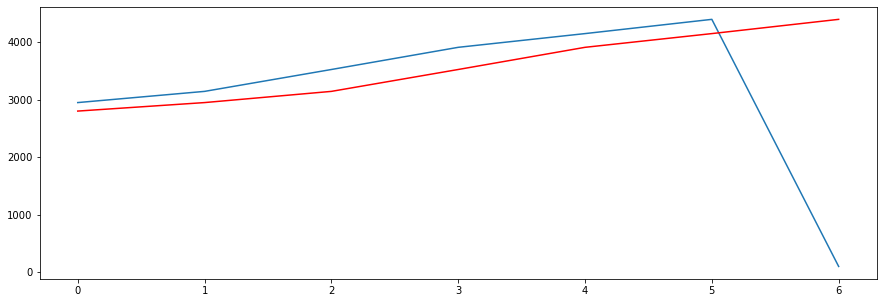

In [17]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = DataFrame(ts_cases.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

### Autoregression Model

Coefficients: [22.93155033  1.08681933]
predicted=3068.199310, expected=2950.000000
predicted=3357.509865, expected=3145.000000
predicted=3671.938169, expected=3526.000000
predicted=4013.664927, expected=3912.000000
predicted=4385.060172, expected=4151.000000
predicted=4788.699704, expected=4399.000000
predicted=5227.382949, expected=97.000000
Test MSE: 3802606.350


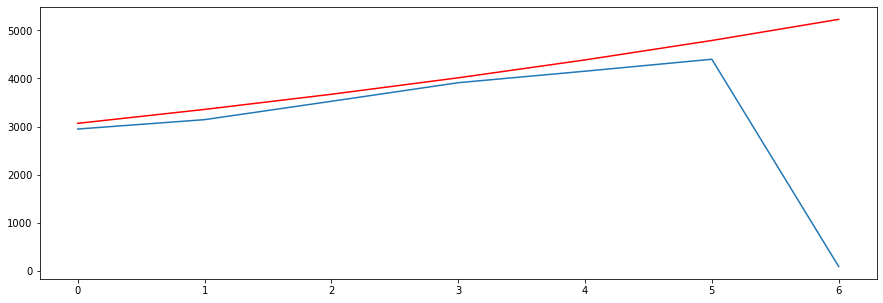

In [18]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
# split dataset
X = ts_cases.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags = 1)
model_fit = model.fit()
#print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Numerical Python Method

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


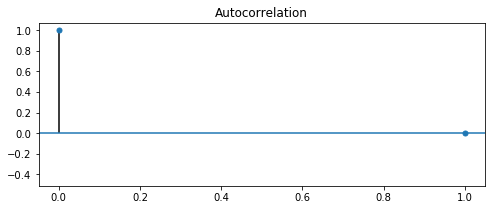

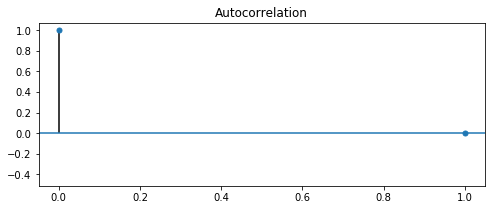

In [20]:
lags = 1
lag = 1
model = sm.tsa.AutoReg(ts_cases, lags = lag)
result = model.fit()
sm.stats.durbin_watson(result.resid)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
smg.tsa.plot_acf(result.resid, lags=lag, ax=ax)

In [21]:
days_to_predict = 5

# Predict Ahead
d2 = parse(cases.Date[len(cases) - 1]) + timedelta(days=days_to_predict)
d1 = parse(cases.Date[len(cases) - 1]) - timedelta(days=1)

# Predict given
#d2 = parse(cases.Date[len(cases) - 1])
#d1 = d2 - timedelta(days=lag)

# All
#d2 = parse(cases.Date[len(cases) - 1])
#d1 = d2 - timedelta(days=number_of_days - 1)

forecast = result.predict(d1, d2)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(ts_cases.index.values[:-lag], ts_cases.values[:-lag], label="train data")
#ax.plot(ts_cases.index.values[-lag - 1:], ts_cases.values[-lag - 1:],label= "actual outcome")
ax.plot(pd.date_range(d1, d2, freq="D").values, forecast, label="predicted outcome")
ax.grid(b='on', which='major', color='k', linewidth=0.5)
ax.grid(b='on', which='minor', color='k', linewidth=0.5)
ax.set_facecolor("w")
fig.tight_layout()
ax.legend()

fig.savefig('Model' + ".png")

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [22]:
result.predict(parse('2020-03-27'), parse('2020-04-3'))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   21
Model:                     AutoReg(1)   Log Likelihood                -164.571
Method:               Conditional MLE   S.D. of innovations            906.522
Date:                Mon, 11 May 2020   AIC                             13.919
Time:                        20:06:18   BIC                             14.069
Sample:                             1   HQIC                            13.948
                                   21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    727.0438    448.705      1.620      0.105    -152.402    1606.489
y.L1           0.6612      0.180      3.683      0.000       0.309       1.013
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5123           +0.0000j            1.5123            0.0000
-----------------------------------------------------------------------------
"""

### RNN

In [98]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

### Create Dataset

In [99]:
cases_country_raw = cases_raw[pd.isna(cases_raw["Province/State"])]
cases_country_raw.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
243,NaN,Mali,17.570692,-3.996166,0,0,0,0,0,0,...,0,0,0,0,0,2,4,11,18,18
244,NaN,Saint Kitts and Nevis,17.357822,-62.782998,0,0,0,0,0,0,...,0,0,0,0,0,2,2,2,2,2
247,NaN,Kosovo,42.602636,20.902977,0,0,0,0,0,0,...,0,0,0,0,0,0,71,86,91,94
248,NaN,Burma,21.916200,95.956000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,8,10
252,NaN,MS Zaandam,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2


In [100]:
cases_country=cases_country_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'],value_name='Cases',var_name='Date').reset_index()
cases_country.head()

,index,Province/State,Country/Region,Lat,Long,Date,Cases
0,0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0
1,1,NaN,Albania,41.1533,20.1683,1/22/20,0
2,2,NaN,Algeria,28.0339,1.6596,1/22/20,0
3,3,NaN,Andorra,42.5063,1.5218,1/22/20,0
4,4,NaN,Angola,-11.2027,17.8739,1/22/20,0


In [101]:
countries = cases_country['Country/Region']
number_of_days = 20
d2 = parse(cases_country.Date[len(cases_country) - 1])
d1 = d2 - timedelta(days=number_of_days)
series = np.empty([len(countries), number_of_days + 1])
n_steps = number_of_days
n = len(countries) - 1
i = 0

for country in countries:
    mask = cases_country["Country/Region"] == country
    df_specific = cases_country[mask]
    df_specific = df_specific.reset_index()
    series[i] = np.array(df_specific.Cases[-n_steps - 1:])
    i+=1
    
series = series[..., np.newaxis].astype(np.float32)

In [228]:
# Overfit
countries = cases_country['Country/Region']
number_of_days = 20
d2 = parse(cases_country.Date[len(cases_country) - 1])
d1 = d2 - timedelta(days=number_of_days)
series = np.empty([len(countries), number_of_days + 1])
n_steps = number_of_days
n = len(countries) - 1
country = "Nigeria"

for i in range(n):
    mask = cases_country["Country/Region"] == country
    df_specific = cases_country[mask]
    df_specific = df_specific.reset_index()
    series[i] = np.array(df_specific.Cases[-n_steps - 1:])
    i+=1
    
series = series[..., np.newaxis].astype(np.float32)

In [229]:
print(series.shape)

(11832, 21, 1)


In [230]:
val = 300
test = 100
X_train, y_train = series[:n - val - test, :n_steps], series[:n - val - test, -1]
X_valid, y_valid = series[n - val:n, :n_steps], series[n - val:n, -1]
X_test, y_test = series[n-test+1:, :n_steps], series[n-test+1:, -1]

In [231]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(11431, 1)
(300, 1)
(100, 1)


In [232]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(11431, 20, 1)
(300, 20, 1)
(100, 20, 1)


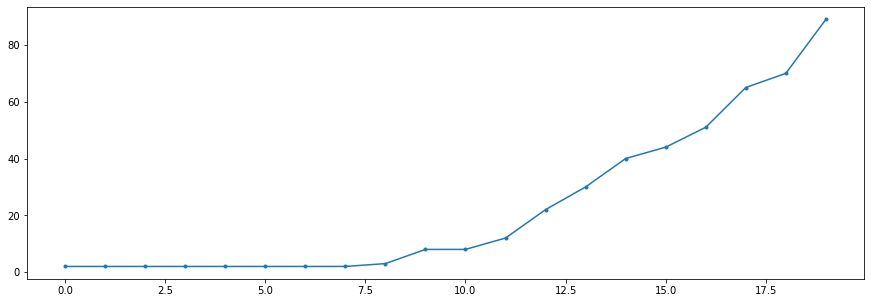

In [233]:
plt.plot(X_train[3, : , 0], ".-")

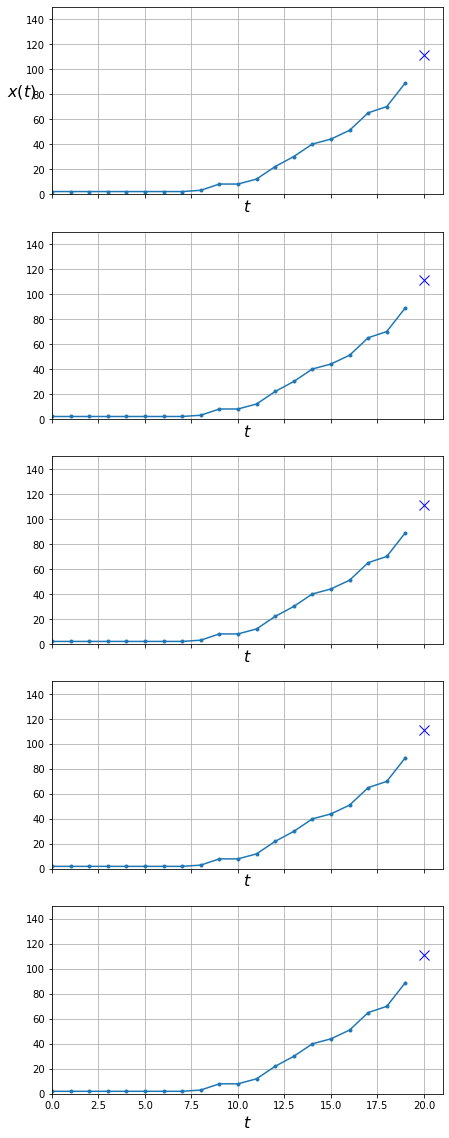

In [254]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 150])

rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=1, sharex=True, figsize=(7, 20))
for row in range(rows):
    plt.sca(axes[row])
    plot_series(X_train[row, :, 0], y_train[row, 0],
                y_label=("$x(t)$" if row==0 else None))
#save_fig("time_series_plot")
plt.show()

In [237]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 11431 samples, validate on 300 samples
Epoch 1/20
11431/11431 [==============================] - 10s 906us/sample - loss: 10658.4565 - val_loss: 9769.3613
Epoch 2/20
11431/11431 [==============================] - 7s 615us/sample - loss: 9056.4407 - val_loss: 8368.5977
Epoch 3/20
11431/11431 [==============================] - 7s 630us/sample - loss: 7741.9547 - val_loss: 7133.8354
Epoch 4/20
11431/11431 [==============================] - 7s 653us/sample - loss: 6577.3528 - val_loss: 6037.0498
Epoch 5/20
11431/11431 [==============================] - 7s 639us/sample - loss: 5542.8735 - val_loss: 5063.4463
Epoch 6/20
11431/11431 [==============================] - 7s 627us/sample - loss: 4625.9762 - val_loss: 4202.2109
Epoch 7/20
11431/11431 [==============================] - 7s 616us/sample - loss: 3816.9490 - val_loss: 3444.5598
Epoch 8/20
11431/11431 [==============================] - 7s 615us/sample - loss: 3107.6742 - val_loss: 2782.9590
Epoch 9/20
11431/11431 [==============

In [241]:
model.evaluate(X_valid, y_valid)

300/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

11.169034004211426

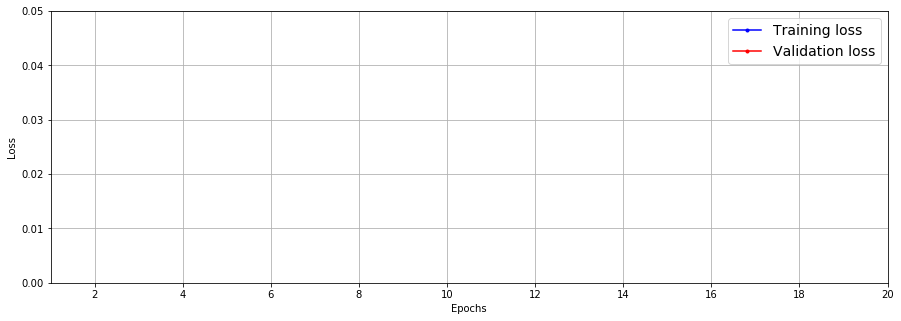

In [242]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [270]:
index = 1000
y_pred = model.predict(series[0, :, 0])
plot_series(X_train[index, :, 0], y_train[index, 0], y_pred[-1, 0])
plt.show()

ValueError: Error when checking input: expected simple_rnn_4_input to have 3 dimensions, but got array with shape (21, 1)

In [259]:
y_pred[-1, 0]

107.47534

In [269]:
series[0, :, 0]

array([  2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   8.,   8.,
        12.,  22.,  30.,  40.,  44.,  51.,  65.,  70.,  89., 111.],
      dtype=float32)

In [296]:
np.array(ts_cases)

array([  2.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   8.,   8.,  12.,
        22.,  30.,  40.,  44.,  51.,  65.,  70.,  89., 111., 131.])

In [311]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [312]:
#dataset = np.array(ts_cases)

# fix random seed for reproducibility
numpy.random.seed(7)

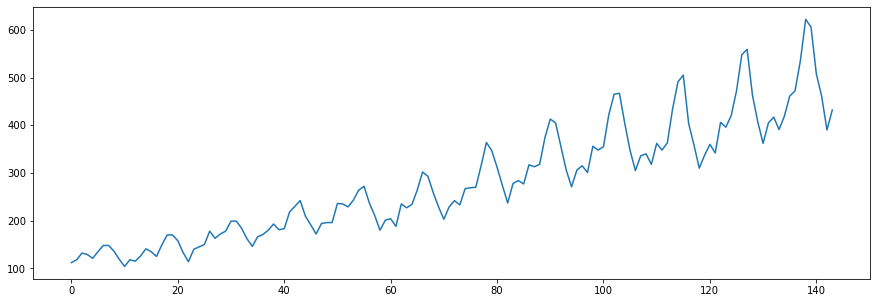

In [337]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

In [459]:
#dataset[1]
dataset = np.array(ts_cases).reshape(20, 1)

In [460]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [461]:
i = 2
print(dataset[-i])
temp = dataset
print(scaler.inverse_transform(temp)[-i])

[0.84496124]
[111.]


In [492]:
# split into train and test sets
train_size = int(len(dataset) * (16/20))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

16 4


In [493]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [506]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [507]:
for i in range(15):
    print(trainX[-i], trainY[-i])

[0.] 0.0
[0.3255814] 0.3798449612403101
[0.29457364] 0.32558139534883723
[0.21705426] 0.2945736434108527
[0.15503876] 0.21705426356589147
[0.07751938] 0.15503875968992248
[0.04651163] 0.07751937984496124
[0.04651163] 0.046511627906976744
[0.00775194] 0.046511627906976744
[0.] 0.007751937984496124
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0


In [510]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [519]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(14, 1, 1) (1, 14)
(2, 1, 1) (1, 2)


In [512]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
 - 1s - loss: 0.0257
Epoch 2/1000
 - 0s - loss: 0.0227
Epoch 3/1000
 - 0s - loss: 0.0205
Epoch 4/1000
 - 0s - loss: 0.0186
Epoch 5/1000
 - 0s - loss: 0.0172
Epoch 6/1000
 - 0s - loss: 0.0163
Epoch 7/1000
 - 0s - loss: 0.0154
Epoch 8/1000
 - 0s - loss: 0.0148
Epoch 9/1000
 - 0s - loss: 0.0144
Epoch 10/1000
 - 0s - loss: 0.0143
Epoch 11/1000
 - 0s - loss: 0.0137
Epoch 12/1000
 - 0s - loss: 0.0135
Epoch 13/1000
 - 0s - loss: 0.0132
Epoch 14/1000
 - 0s - loss: 0.0129
Epoch 15/1000
 - 0s - loss: 0.0128
Epoch 16/1000
 - 0s - loss: 0.0126
Epoch 17/1000
 - 0s - loss: 0.0123
Epoch 18/1000
 - 0s - loss: 0.0121
Epoch 19/1000
 - 0s - loss: 0.0120
Epoch 20/1000
 - 0s - loss: 0.0117
Epoch 21/1000
 - 0s - loss: 0.0115
Epoch 22/1000
 - 0s - loss: 0.0113
Epoch 23/1000
 - 0s - loss: 0.0111
Epoch 24/1000
 - 0s - loss: 0.0108
Epoch 25/1000
 - 0s - loss: 0.0106
Epoch 26/1000
 - 0s - loss: 0.0105
Epoch 27/1000
 - 0s - loss: 0.0104
Epoch 28/1000
 - 0s - loss: 0.0100
Epoch 29/1000
 - 0s - loss: 0

Epoch 217/1000
 - 0s - loss: 5.0840e-04
Epoch 218/1000
 - 0s - loss: 5.1164e-04
Epoch 219/1000
 - 0s - loss: 5.1229e-04
Epoch 220/1000
 - 0s - loss: 5.1298e-04
Epoch 221/1000
 - 0s - loss: 5.0367e-04
Epoch 222/1000
 - 0s - loss: 5.0401e-04
Epoch 223/1000
 - 0s - loss: 5.0843e-04
Epoch 224/1000
 - 0s - loss: 5.4078e-04
Epoch 225/1000
 - 0s - loss: 5.0754e-04
Epoch 226/1000
 - 0s - loss: 5.0604e-04
Epoch 227/1000
 - 0s - loss: 5.0391e-04
Epoch 228/1000
 - 0s - loss: 5.2629e-04
Epoch 229/1000
 - 0s - loss: 5.0097e-04
Epoch 230/1000
 - 0s - loss: 5.0250e-04
Epoch 231/1000
 - 0s - loss: 4.9876e-04
Epoch 232/1000
 - 0s - loss: 5.0004e-04
Epoch 233/1000
 - 0s - loss: 5.0986e-04
Epoch 234/1000
 - 0s - loss: 5.0819e-04
Epoch 235/1000
 - 0s - loss: 5.0118e-04
Epoch 236/1000
 - 0s - loss: 5.0202e-04
Epoch 237/1000
 - 0s - loss: 5.1139e-04
Epoch 238/1000
 - 0s - loss: 5.0780e-04
Epoch 239/1000
 - 0s - loss: 5.0020e-04
Epoch 240/1000
 - 0s - loss: 4.9021e-04
Epoch 241/1000
 - 0s - loss: 4.9210e-04


Epoch 422/1000
 - 0s - loss: 4.3078e-04
Epoch 423/1000
 - 0s - loss: 4.2917e-04
Epoch 424/1000
 - 0s - loss: 4.4090e-04
Epoch 425/1000
 - 0s - loss: 4.6017e-04
Epoch 426/1000
 - 0s - loss: 4.1985e-04
Epoch 427/1000
 - 0s - loss: 4.2286e-04
Epoch 428/1000
 - 0s - loss: 4.2428e-04
Epoch 429/1000
 - 0s - loss: 4.0884e-04
Epoch 430/1000
 - 0s - loss: 4.2653e-04
Epoch 431/1000
 - 0s - loss: 4.1911e-04
Epoch 432/1000
 - 0s - loss: 4.4066e-04
Epoch 433/1000
 - 0s - loss: 4.5205e-04
Epoch 434/1000
 - 0s - loss: 4.2657e-04
Epoch 435/1000
 - 0s - loss: 4.2075e-04
Epoch 436/1000
 - 0s - loss: 4.1678e-04
Epoch 437/1000
 - 0s - loss: 4.0615e-04
Epoch 438/1000
 - 0s - loss: 4.1862e-04
Epoch 439/1000
 - 0s - loss: 4.1511e-04
Epoch 440/1000
 - 0s - loss: 4.3405e-04
Epoch 441/1000
 - 0s - loss: 4.2097e-04
Epoch 442/1000
 - 0s - loss: 4.2375e-04
Epoch 443/1000
 - 0s - loss: 4.1172e-04
Epoch 444/1000
 - 0s - loss: 4.0652e-04
Epoch 445/1000
 - 0s - loss: 4.1725e-04
Epoch 446/1000
 - 0s - loss: 4.1292e-04


Epoch 627/1000
 - 0s - loss: 3.5343e-04
Epoch 628/1000
 - 0s - loss: 3.3411e-04
Epoch 629/1000
 - 0s - loss: 4.0472e-04
Epoch 630/1000
 - 0s - loss: 3.9345e-04
Epoch 631/1000
 - 0s - loss: 3.5196e-04
Epoch 632/1000
 - 0s - loss: 3.4786e-04
Epoch 633/1000
 - 0s - loss: 3.5781e-04
Epoch 634/1000
 - 0s - loss: 3.4691e-04
Epoch 635/1000
 - 0s - loss: 3.4940e-04
Epoch 636/1000
 - 0s - loss: 3.4094e-04
Epoch 637/1000
 - 0s - loss: 3.3435e-04
Epoch 638/1000
 - 0s - loss: 3.4457e-04
Epoch 639/1000
 - 0s - loss: 3.6237e-04
Epoch 640/1000
 - 0s - loss: 3.3833e-04
Epoch 641/1000
 - 0s - loss: 3.4153e-04
Epoch 642/1000
 - 0s - loss: 3.4059e-04
Epoch 643/1000
 - 0s - loss: 3.4158e-04
Epoch 644/1000
 - 0s - loss: 3.4154e-04
Epoch 645/1000
 - 0s - loss: 3.3501e-04
Epoch 646/1000
 - 0s - loss: 3.3463e-04
Epoch 647/1000
 - 0s - loss: 3.5455e-04
Epoch 648/1000
 - 0s - loss: 3.4063e-04
Epoch 649/1000
 - 0s - loss: 3.3938e-04
Epoch 650/1000
 - 0s - loss: 3.3838e-04
Epoch 651/1000
 - 0s - loss: 3.4018e-04


Epoch 832/1000
 - 0s - loss: 3.0121e-04
Epoch 833/1000
 - 0s - loss: 3.0832e-04
Epoch 834/1000
 - 0s - loss: 2.9368e-04
Epoch 835/1000
 - 0s - loss: 3.0518e-04
Epoch 836/1000
 - 0s - loss: 3.0478e-04
Epoch 837/1000
 - 0s - loss: 3.1072e-04
Epoch 838/1000
 - 0s - loss: 2.9609e-04
Epoch 839/1000
 - 0s - loss: 3.0166e-04
Epoch 840/1000
 - 0s - loss: 3.0148e-04
Epoch 841/1000
 - 0s - loss: 3.4660e-04
Epoch 842/1000
 - 0s - loss: 3.2535e-04
Epoch 843/1000
 - 0s - loss: 3.0533e-04
Epoch 844/1000
 - 0s - loss: 3.0527e-04
Epoch 845/1000
 - 0s - loss: 2.9534e-04
Epoch 846/1000
 - 0s - loss: 3.0577e-04
Epoch 847/1000
 - 0s - loss: 3.3482e-04
Epoch 848/1000
 - 0s - loss: 2.9523e-04
Epoch 849/1000
 - 0s - loss: 3.2318e-04
Epoch 850/1000
 - 0s - loss: 3.0631e-04
Epoch 851/1000
 - 0s - loss: 2.9922e-04
Epoch 852/1000
 - 0s - loss: 3.1919e-04
Epoch 853/1000
 - 0s - loss: 2.9881e-04
Epoch 854/1000
 - 0s - loss: 3.2760e-04
Epoch 855/1000
 - 0s - loss: 3.4608e-04
Epoch 856/1000
 - 0s - loss: 3.2319e-04


In [513]:
#trainPredict = model.predict(testX)
print(scaler.inverse_transform(testPredict)[-1])

[8055.052]


In [514]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.13 RMSE
Test Score: 46.51 RMSE


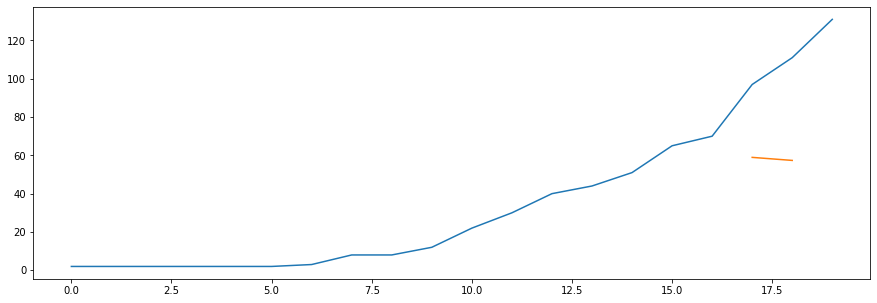

In [543]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [555]:
testX.shape

(2, 1, 1)

In [568]:
tX = np.array(131)
tX = tX[..., np.newaxis].astype(np.float32)
tX = tX[..., np.newaxis].astype(np.float32)
tX = scaler.fit_transform(tX)
tX

array([[0.]], dtype=float32)

In [571]:
tY = model.predict(tX)
scaler.inverse_transform(tY)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

Epoch 1/100
 - 1s - loss: 0.0544
Epoch 2/100
 - 0s - loss: 0.0301
Epoch 3/100
 - 0s - loss: 0.0215
Epoch 4/100
 - 0s - loss: 0.0192
Epoch 5/100
 - 0s - loss: 0.0183
Epoch 6/100
 - 0s - loss: 0.0176
Epoch 7/100
 - 0s - loss: 0.0170
Epoch 8/100
 - 0s - loss: 0.0166
Epoch 9/100
 - 0s - loss: 0.0158
Epoch 10/100
 - 0s - loss: 0.0150
Epoch 11/100
 - 0s - loss: 0.0144
Epoch 12/100
 - 0s - loss: 0.0137
Epoch 13/100
 - 0s - loss: 0.0128
Epoch 14/100
 - 0s - loss: 0.0121
Epoch 15/100
 - 0s - loss: 0.0113
Epoch 16/100
 - 0s - loss: 0.0105
Epoch 17/100
 - 0s - loss: 0.0097
Epoch 18/100
 - 0s - loss: 0.0088
Epoch 19/100
 - 0s - loss: 0.0081
Epoch 20/100
 - 0s - loss: 0.0073
Epoch 21/100
 - 0s - loss: 0.0065
Epoch 22/100
 - 0s - loss: 0.0058
Epoch 23/100
 - 0s - loss: 0.0051
Epoch 24/100
 - 0s - loss: 0.0045
Epoch 25/100
 - 0s - loss: 0.0041
Epoch 26/100
 - 0s - loss: 0.0036
Epoch 27/100
 - 0s - loss: 0.0032
Epoch 28/100
 - 0s - loss: 0.0029
Epoch 29/100
 - 0s - loss: 0.0027
Epoch 30/100
 - 0s - lo

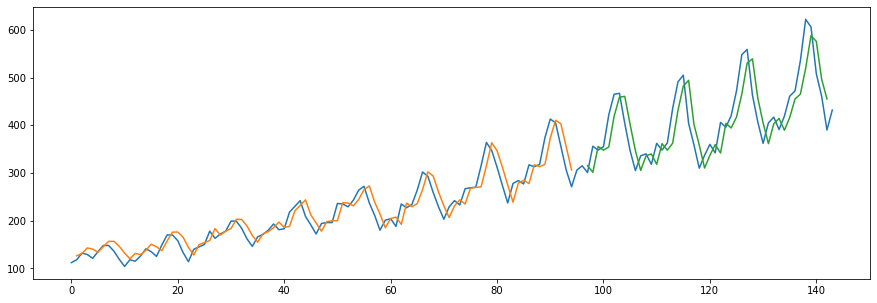

In [358]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()